In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import wcsaxes
from astropy.visualization import ImageNormalize
from astropy.visualization import LogStretch
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
import pandas as pd
import pyfits as pf
from astropy.table import Table, hstack, join

/Users/shrustisahu/Library/Python/3.8/lib/python/site-packages/pyfits/__init__.py:21: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  warnings.warn('PyFITS is deprecated, please use astropy.io.fits',


In [59]:

import glob

In [60]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

In [61]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

In [62]:
hdul = fits.open('mosaic-blanked.fits')
image_data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

hdul.close()

To extract the pixel coordinates of significant sources from your image and convert them to celestial coordinates using the WCS (World Coordinate System) information from the FITS header, you can follow these steps using Python and the astropy library. This process involves identifying sources, converting their pixel coordinates to celestial coordinates, and then using these coordinates for further analysis or cross-matching with astronomical databases.

In [63]:
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

# Initialize the star finder class
daofind = DAOStarFinder(fwhm=3.0, threshold=5*std)  # Adjust parameters as needed
sources = daofind(image_data - median)

# Display the first few sources
# print(sources[:5])

In [64]:
px, py = 3946.3099580744865, 5594.5  # These should be actual detected source positions
ra_dec = wcs.pixel_to_world(px, py)

print(f"RA: {ra_dec.ra.deg}, Dec: {ra_dec.dec.deg}")

RA: 0.2689430944715343, Dec: 23.864501210088303


In [65]:
# Convert pixel coordinates to celestial coordinates (RA, Dec)
celestial_coords = wcs.pixel_to_world(sources['xcentroid'], sources['ycentroid'])

# Display the celestial coordinates
#print("ID    RA           Dec         Flux")
#for idx, coord in enumerate(celestial_coords):
#    print(f"{sources['id'][idx]}  {coord.ra.deg:.6f}  {coord.dec.deg:.6f}  {sources['flux'][idx]}")



# contour plot of whole IMAGE

In [66]:
nan_exists = np.isnan(image_data).any()
print(f"Are there NaN values in the data? {nan_exists}")

# If NaN values exist, you might want to ignore them in your calculations or fill them
if nan_exists:
    # Calculate statistics ignoring NaN values
    mean_flux = np.nanmean(image_data)
    std_flux = np.nanstd(image_data)
    max_flux = np.nanmax(image_data)
    min_flux = np.nanmin(image_data)
    print(f"Mean Flux Density: {mean_flux} Jy")
    print(f"Standard Deviation of Flux Density: {std_flux} Jy")
    print(f"Maximum Flux Density: {max_flux} Jy")
    print(f"Minimum Flux Density: {min_flux} Jy")

Are there NaN values in the data? True
Mean Flux Density: 1.3790480335984743e-05 Jy
Standard Deviation of Flux Density: 0.00141703487709128 Jy
Maximum Flux Density: 2.1456338791115113 Jy
Minimum Flux Density: -0.008286226443467529 Jy


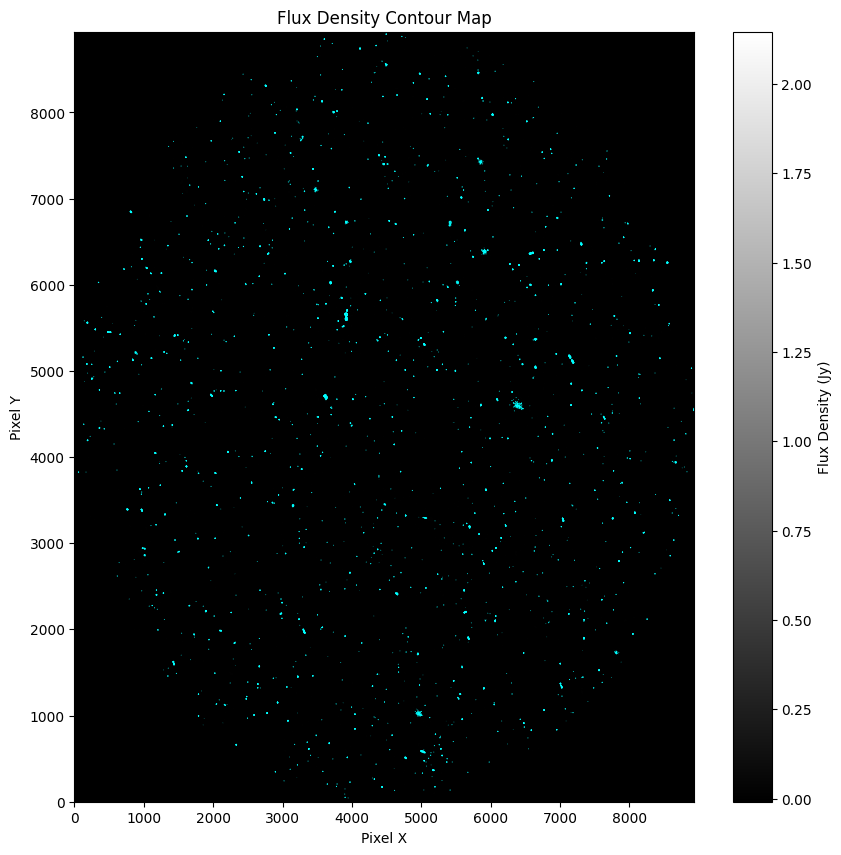

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'image_data' is the original data with NaN values handled
filled_data = np.nan_to_num(image_data, nan=np.nanmean(image_data))

# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(filled_data, origin='lower', cmap='gray', aspect='auto')
plt.colorbar(label='Flux Density (Jy)')

# Define contour levels based on meaningful deviations above the noise
contour_levels = [mean_flux + n * std_flux for n in range(1, 10) if mean_flux + n * std_flux < max_flux]
plt.contour(filled_data, levels=contour_levels, colors='cyan', linewidths=0.5)

plt.title('Flux Density Contour Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


## contour plot of LOFAR Data
### J000107 + 235323 , J000107 + 235220

In [68]:
# Define the center of the region of interest
x_center, y_center = 3924, 5631
half_size = 50  # This results in a 100x100 pixel box

# Calculate the bounds of the region
x_min = int(x_center - half_size)
x_max = int(x_center + half_size)
y_min = int(y_center - half_size)
y_max = int(y_center + half_size)

filled_data = np.nan_to_num(image_data, nan=np.nanmean(image_data))
# Crop the image data
cropped_image = filled_data[y_min:y_max, x_min:x_max]
sigma = np.std(cropped_image) # Standard deviation
mean = np.mean(cropped_image) # mean

# Set contour levels at multiples of the noise level (sigma)
multiplication_factors = np.arange(0, 10)  # From -3σ to +9σ
contour_levels = mean + sigma * multiplication_factors

# Checking the generated contour levels
print("Contour levels:", contour_levels)

Contour levels: [0.00379944 0.01537321 0.02694697 0.03852074 0.0500945  0.06166826
 0.07324203 0.08481579 0.09638956 0.10796332]


In [ ]:
# Print the data statistics
print("Minimum value in the image:", np.min(cropped_image))
print("Maximum value in the image:", np.max(cropped_image))
print("Mean value of the image:", mean)
print("Standard deviation of the image:", sigma)

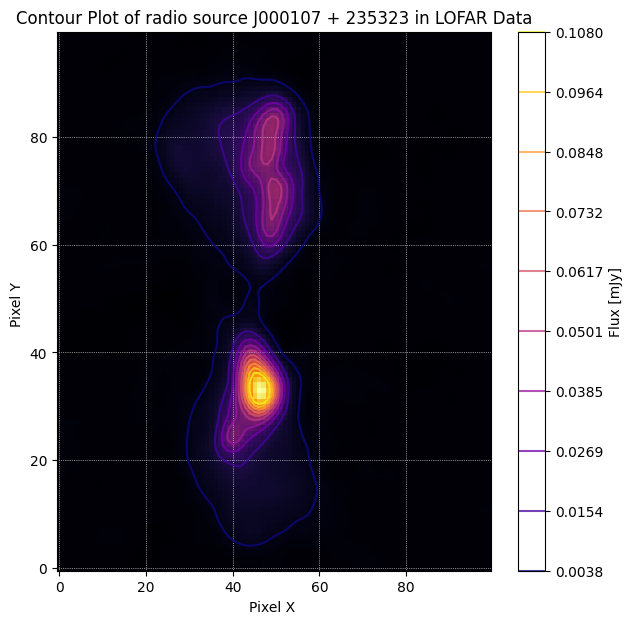

In [69]:
plt.figure(figsize=(7, 7))
plt.imshow(cropped_image, origin='lower', cmap='inferno', aspect='auto')
contour = plt.contour(cropped_image, levels=contour_levels, cmap='plasma', alpha=0.75)
#plt.clabel(contour, inline=True, fontsize=4, fmt='%1.4f')
plt.colorbar(contour, label='Flux [mJy]')
plt.title('Contour Plot of radio source J000107 + 235323 in LOFAR Data')
plt.xlabel('Pixel X ')
plt.ylabel('Pixel Y ')
plt.grid(color='white', linestyle=':', linewidth=0.5)

plt.show()

/var/folders/qc/542j3x6s4fvcwt02s2bpf5ym0000gn/T/ipykernel_61747/1541035107.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(cropped_image, levels=log_levels, colors='cyan', norm=LogNorm())


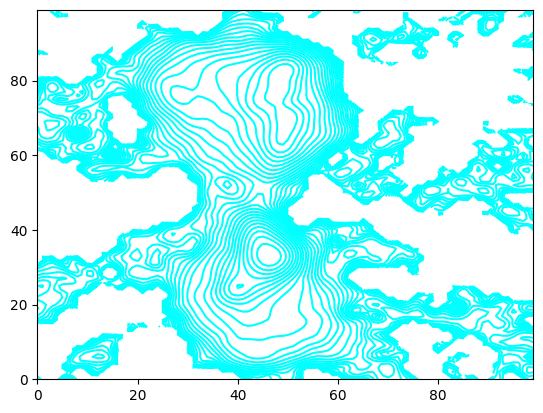

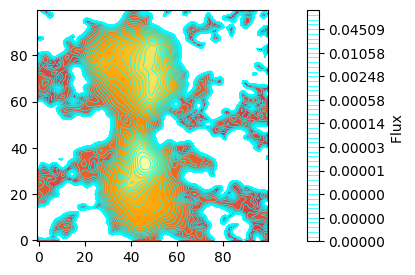

In [70]:
log_levels = np.logspace(start=np.log10(np.min(cropped_image[cropped_image > 0])), stop=np.log10(np.max(cropped_image)), num=50)
plt.contour(cropped_image, levels=log_levels, colors='cyan', norm=LogNorm())

plt.figure(figsize=(10, 3))
plt.imshow(cropped_image, cmap='inferno', origin='lower', norm=LogNorm())
contour = plt.contour(cropped_image, levels=log_levels, colors='cyan', linewidths=0.5)
cbar = plt.colorbar(contour)
cbar.set_label('Flux ')
cbar.add_lines(contour)